## Set up

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import lightning.pytorch as pl
import torch
import pickle
import scipy.stats as st
import statsmodels.api as sm
import itertools

from datetime import datetime, timedelta
from tqdm import tqdm

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

In [125]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Import the data

In [126]:
features_df = pd.read_json('../../dataset/combined_retails_and_exog_data/combined_data.json')
features_df

,Date,TimeIdx,Description,AvgPricePerUnitPounds,DayBeforeUnitsSold,DayBeforeLog1pUnitsSold,WeekBeforeUnitsSold,WeekBeforeLog1pUnitsSold,Rolling3DayMeanUnitsSold,Rolling3DayMeanLog1pUnitsSold,...,IsWeekend,DayOfWeek,DayOfMonth,Month,Quarter,CCI,CPI,InterestRate,Unemployment,IsHoliday
0,2009-12-01,1,12 pencils small tube red spotty,0.66,0,0.000000,0,0.000000,0.000000,0.000000,...,False,Tuesday,1,December,Q4,101.64,90.7,0.4517,7.7,False
1,2009-12-02,2,12 pencils small tube red spotty,0.71,45,3.828641,0,0.000000,0.000000,0.000000,...,False,Wednesday,2,December,Q4,101.64,90.7,0.4532,7.7,False
2,2009-12-03,3,12 pencils small tube red spotty,0.69,87,4.477337,0,0.000000,0.000000,0.000000,...,False,Thursday,3,December,Q4,101.64,90.7,0.4522,7.7,False
3,2009-12-04,4,12 pencils small tube red spotty,0.66,34,3.555348,0,0.000000,55.333333,4.031286,...,False,Friday,4,December,Q4,101.64,90.7,0.4502,7.7,False
4,2009-12-05,5,12 pencils small tube red spotty,0.65,84,4.442651,0,0.000000,68.333333,4.238926,...,True,Saturday,5,December,Q4,101.64,90.7,0.4502,7.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104933,2011-12-05,735,wood black board ant white finish,7.70,5,1.791759,2,1.098612,9.666667,2.367124,...,False,Monday,5,December,Q4,98.18,95.2,0.5273,8.3,False
104934,2011-12-06,736,wood black board ant white finish,7.95,23,3.178054,8,2.197225,9.333333,2.335375,...,False,Tuesday,6,December,Q4,98.18,95.2,0.5272,8.3,False
104935,2011-12-07,737,wood black board ant white finish,6.92,4,1.609438,29,3.401197,10.666667,2.456736,...,False,Wednesday,7,December,Q4,98.18,95.2,0.5264,8.3,False
104936,2011-12-08,738,wood black board ant white finish,5.05,70,4.262680,36,3.610918,32.333333,3.506558,...,False,Thursday,8,December,Q4,98.18,95.2,0.5392,8.3,False


## Prepare the dataset

In [127]:
# Select features and drop NaNs
ols_df = features_df[[
    'Description',
    'UnitsSold',  # target
    'AvgPricePerUnitPounds',
    'CCI',
    'CPI',
    'InterestRate',
    'Unemployment',
    'DayBeforeUnitsSold',
    'WeekBeforeUnitsSold',
    'Rolling3DayMeanUnitsSold',
    'Rolling7DayMeanUnitsSold',
    'IsWeekend',
    'IsHoliday',
    'DayOfWeek',
    'Month',
    'Quarter',
]].copy()

# Convert categoricals to dummy variables
categorical_cols = ['DayOfWeek', 'Month', 'Quarter']
ols_df = pd.get_dummies(ols_df, columns=categorical_cols, drop_first=True)

for col in ols_df.select_dtypes(include="bool").columns:
    ols_df[col] = ols_df[col].astype(int)

# Define lag and calendar features
lag_features = [
    'DayBeforeUnitsSold',
    'WeekBeforeUnitsSold',
    'Rolling3DayMeanUnitsSold',
    'Rolling7DayMeanUnitsSold',
]

calendar_features = ['IsWeekend', 'IsHoliday']

# Add interaction terms
for lag, cal in itertools.product(lag_features, calendar_features):
    interaction_name = f"{lag}_x_{cal}"
    ols_df[interaction_name] = ols_df[lag] * ols_df[cal]

print(ols_df.columns)
ols_df

Index(['Description', 'UnitsSold', 'AvgPricePerUnitPounds', 'CCI', 'CPI',
       'InterestRate', 'Unemployment', 'DayBeforeUnitsSold',
       'WeekBeforeUnitsSold', 'Rolling3DayMeanUnitsSold',
       'Rolling7DayMeanUnitsSold', 'IsWeekend', 'IsHoliday',
       'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Sunday',
       'DayOfWeek_Thursday', 'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday',
       'Month_August', 'Month_December', 'Month_February', 'Month_January',
       'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September', 'Quarter_Q2',
       'Quarter_Q3', 'Quarter_Q4', 'DayBeforeUnitsSold_x_IsWeekend',
       'DayBeforeUnitsSold_x_IsHoliday', 'WeekBeforeUnitsSold_x_IsWeekend',
       'WeekBeforeUnitsSold_x_IsHoliday',
       'Rolling3DayMeanUnitsSold_x_IsWeekend',
       'Rolling3DayMeanUnitsSold_x_IsHoliday',
       'Rolling7DayMeanUnitsSold_x_IsWeekend',
       'Rolling7DayMeanUnitsSold_x_IsHoliday'],
      dtype='o

,Description,UnitsSold,AvgPricePerUnitPounds,CCI,CPI,InterestRate,Unemployment,DayBeforeUnitsSold,WeekBeforeUnitsSold,Rolling3DayMeanUnitsSold,...,Quarter_Q3,Quarter_Q4,DayBeforeUnitsSold_x_IsWeekend,DayBeforeUnitsSold_x_IsHoliday,WeekBeforeUnitsSold_x_IsWeekend,WeekBeforeUnitsSold_x_IsHoliday,Rolling3DayMeanUnitsSold_x_IsWeekend,Rolling3DayMeanUnitsSold_x_IsHoliday,Rolling7DayMeanUnitsSold_x_IsWeekend,Rolling7DayMeanUnitsSold_x_IsHoliday
0,12 pencils small tube red spotty,45,0.66,101.64,90.7,0.4517,7.7,0,0,0.000000,...,0,1,0,0,0,0,0.000000,0.0,0.0,0.0
1,12 pencils small tube red spotty,87,0.71,101.64,90.7,0.4532,7.7,45,0,0.000000,...,0,1,0,0,0,0,0.000000,0.0,0.0,0.0
2,12 pencils small tube red spotty,34,0.69,101.64,90.7,0.4522,7.7,87,0,0.000000,...,0,1,0,0,0,0,0.000000,0.0,0.0,0.0
3,12 pencils small tube red spotty,84,0.66,101.64,90.7,0.4502,7.7,34,0,55.333333,...,0,1,0,0,0,0,0.000000,0.0,0.0,0.0
4,12 pencils small tube red spotty,0,0.65,101.64,90.7,0.4502,7.7,84,0,68.333333,...,0,1,84,0,0,0,68.333333,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104933,wood black board ant white finish,23,7.70,98.18,95.2,0.5273,8.3,5,2,9.666667,...,0,1,0,0,0,0,0.000000,0.0,0.0,0.0
104934,wood black board ant white finish,4,7.95,98.18,95.2,0.5272,8.3,23,8,9.333333,...,0,1,0,0,0,0,0.000000,0.0,0.0,0.0
104935,wood black board ant white finish,70,6.92,98.18,95.2,0.5264,8.3,4,29,10.666667,...,0,1,0,0,0,0,0.000000,0.0,0.0,0.0
104936,wood black board ant white finish,226,5.05,98.18,95.2,0.5392,8.3,70,36,32.333333,...,0,1,0,0,0,0,0.000000,0.0,0.0,0.0


In [174]:
# Create the dataset per product
product_datasets = dict()
dates = features_df.loc[ols_df.index, 'Date']
cutoff_train_date = dates.max() - timedelta(days=60)
cutoff_val_date = dates.max() - timedelta(days=30)

for product in ols_df['Description'].unique():
    product_df = ols_df[ols_df['Description'] == product].copy()

    if product_df.shape[0] < 30:
        continue  # skip products with very few data points

    # Get corresponding dates and ensure sort order
    product_dates = features_df.loc[product_df.index, "Date"]
    product_df["Date"] = product_dates
    product_df = product_df.sort_values("Date")

    # Create masks
    train_mask = product_df["Date"] < cutoff_train_date
    val_mask = (product_df["Date"] >= cutoff_train_date) & (product_df["Date"] < cutoff_val_date)
    test_mask = product_df["Date"] >= cutoff_val_date

    # Define X and y
    y = product_df["UnitsSold"]
    X = product_df.drop(columns=["UnitsSold", "Description", "Date"])

    # Apply masks
    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val     = X[val_mask], y[val_mask]
    X_test, y_test   = X[test_mask], y[test_mask]

    if len(X_train) < 10 or len(X_val) < 5 or len(X_test) < 5:
        continue  # skip if any set is too small

    product_datasets[product] = (X_train, y_train, X_val, y_val, X_test, y_test)

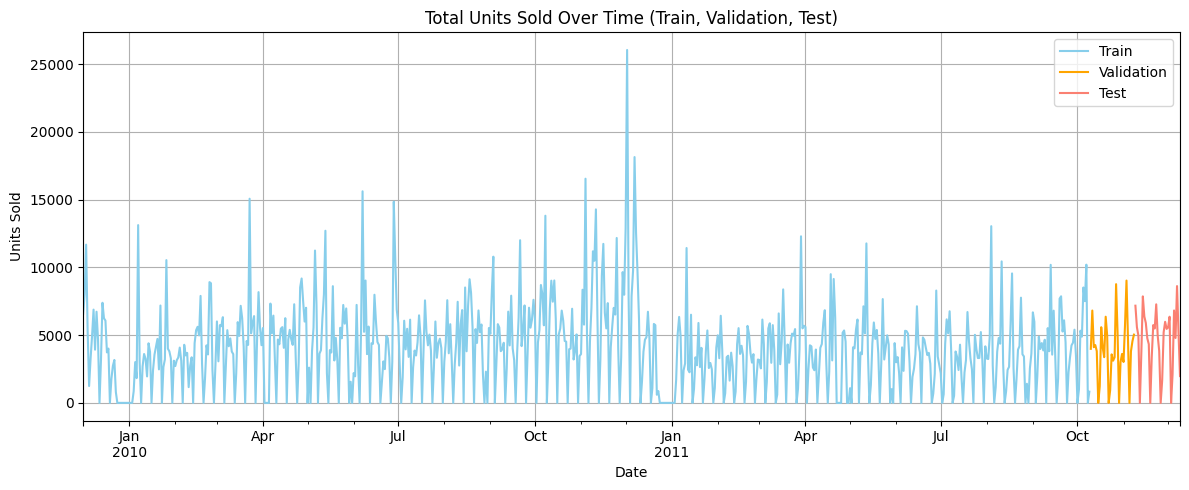

In [129]:
train_sales_by_date = []
val_sales_by_date = []
test_sales_by_date = []

for product, (X_train, y_train, X_val, y_val, X_test, y_test) in product_datasets.items():
    # Use the indices to get corresponding dates
    train_dates = features_df.loc[y_train.index, "Date"]
    val_dates = features_df.loc[y_val.index, "Date"]
    test_dates = features_df.loc[y_test.index, "Date"]

    # Aggregate units sold by date
    train_sales = y_train.groupby(train_dates).sum()
    val_sales = y_val.groupby(val_dates).sum()
    test_sales = y_test.groupby(test_dates).sum()

    train_sales_by_date.append(train_sales)
    val_sales_by_date.append(val_sales)
    test_sales_by_date.append(test_sales)

# Combine and sum over all products
total_train_ts = pd.concat(train_sales_by_date, axis=1).sum(axis=1)
total_val_ts = pd.concat(val_sales_by_date, axis=1).sum(axis=1)
total_test_ts = pd.concat(test_sales_by_date, axis=1).sum(axis=1)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

total_train_ts.sort_index().plot(ax=ax, label="Train", color="skyblue")
total_val_ts.sort_index().plot(ax=ax, label="Validation", color="orange")
total_test_ts.sort_index().plot(ax=ax, label="Test", color="salmon")

ax.set_title("Total Units Sold Over Time (Train, Validation, Test)")
ax.set_xlabel("Date")
ax.set_ylabel("Units Sold")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

## Choose best features for each product

In [130]:
def smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    return np.mean(200 * np.abs(y_true - y_pred) / np.where(denominator == 0, 1e-8, denominator))

def forward_stepwise_selection(X_train, y_train, X_val, y_val, max_features=None):
    remaining = list(X_train.columns.drop("const"))
    selected = []
    best_smape = float("inf")
    best_model = None

    if max_features is None:
        max_features = len(remaining)

    for _ in range(max_features):
        smape_candidates = []
        for candidate in remaining:
            trial_features = selected + [candidate]
            X_train_sub = sm.add_constant(X_train[trial_features], has_constant="add").astype(float)
            X_val_sub = sm.add_constant(X_val[trial_features], has_constant="add").astype(float)

            model = sm.OLS(y_train, X_train_sub).fit()
            y_val_pred = model.predict(X_val_sub)
            val_smape = smape(y_val, y_val_pred)
            smape_candidates.append((val_smape, candidate, model))

        # Pick the candidate with the best (lowest) smape
        smape_candidates.sort()
        best_candidate_smape, best_candidate, candidate_model = smape_candidates[0]

        # Only add if improvement
        if best_candidate_smape < best_smape:
            best_smape = best_candidate_smape
            selected.append(best_candidate)
            best_model = candidate_model
            remaining.remove(best_candidate)
        else:
            break  # no improvement → stop

    return selected, best_model, best_smape

# Store best models per product
best_models_by_smape = {}

for product, (X_train, y_train, X_val, y_val, X_test, y_test) in tqdm(product_datasets.items()):
    try:
        best_subset, best_model, val_smape = forward_stepwise_selection(X_train, y_train, X_val, y_val)

        # Evaluate on test set
        X_test_subset = sm.add_constant(X_test[best_subset], has_constant="add").astype(float)
        y_test_pred = best_model.predict(X_test_subset)
        test_smape = smape(y_test, y_test_pred)

        best_models_by_smape[product] = {
            "features": best_subset,
            "val_smape": val_smape,
            "test_smape": test_smape,
            "model": best_model,
        }

    except Exception as e:
        print(f"Skipping {product}: {e}")

100%|██████████| 142/142 [01:46<00:00,  1.33it/s]


In [131]:
best_models_by_smape

{'12 pencils small tube red spotty': {'features': ['AvgPricePerUnitPounds',
   'DayOfWeek_Tuesday',
   'InterestRate',
   'Rolling7DayMeanUnitsSold_x_IsWeekend',
   'Month_August',
   'Rolling3DayMeanUnitsSold_x_IsWeekend',
   'DayBeforeUnitsSold_x_IsWeekend',
   'DayBeforeUnitsSold_x_IsHoliday'],
  'val_smape': np.float64(110.14337067035238),
  'test_smape': np.float64(78.41966692956333),
  'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x32dfe48f0>},
 '12 pencils tall tube posy': {'features': ['IsWeekend',
   'Month_October',
   'WeekBeforeUnitsSold_x_IsWeekend',
   'Quarter_Q2',
   'DayOfWeek_Wednesday',
   'Month_August',
   'Month_May',
   'WeekBeforeUnitsSold_x_IsHoliday'],
  'val_smape': np.float64(109.94806038716969),
  'test_smape': np.float64(89.0242377770763),
  'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x32dfd2090>},
 '12 pencils tall tube woodland': {'features': ['Quarter_Q4',
   'AvgPricePerUnitPounds',
   'CCI',


## Train models

In [179]:
models_by_product = {}

for product, (X_train, y_train, _, _, _, _) in tqdm(product_datasets.items()):
    try:
        X_train = X_train.astype(float)

        # Skip if NaNs or infs in features or target
        if not np.isfinite(X_train.values).any() or not np.isfinite(y_train.values).any():
            raise ValueError("NaNs or infs in X or y")

        # Skip if y is all zero (not informative)
        if (y_train == 0).all():
            raise ValueError("All sales are zero")

        # Fit Negative Binomial GLM
        model = sm.GLM(
            y_train,
            X_train,
            family=sm.families.NegativeBinomial(link=sm.families.links.log())
        ).fit()

        models_by_product[product] = model

    except Exception as e:
        print(f"Skipping {product}: {e}")

100%|██████████| 142/142 [00:08<00:00, 17.22it/s]


## Evaluate the models

In [183]:
def generate_lag_features(values: pd.Series, date: pd.Timestamp) -> dict:
    return {
        "DayBeforeUnitsSold": values.get(date - timedelta(days=1), np.nan),
        "WeekBeforeUnitsSold": values.get(date - timedelta(days=7), np.nan),
        "Rolling3DayMeanUnitsSold": values.loc[date - timedelta(days=3):date - timedelta(days=1)].mean(),
        "Rolling7DayMeanUnitsSold": values.loc[date - timedelta(days=7):date - timedelta(days=1)].mean(),
    }

def generate_interaction_features(row: pd.Series) -> dict:
    return {
        "DayBeforeUnitsSold_x_IsWeekend": row["DayBeforeUnitsSold"] * row["IsWeekend"],
        "DayBeforeUnitsSold_x_IsHoliday": row["DayBeforeUnitsSold"] * row["IsHoliday"],
        "WeekBeforeUnitsSold_x_IsWeekend": row["WeekBeforeUnitsSold"] * row["IsWeekend"],
        "WeekBeforeUnitsSold_x_IsHoliday": row["WeekBeforeUnitsSold"] * row["IsHoliday"],
        "Rolling3DayMeanUnitsSold_x_IsWeekend": row["Rolling3DayMeanUnitsSold"] * row["IsWeekend"],
        "Rolling3DayMeanUnitsSold_x_IsHoliday": row["Rolling3DayMeanUnitsSold"] * row["IsHoliday"],
        "Rolling7DayMeanUnitsSold_x_IsWeekend": row["Rolling7DayMeanUnitsSold"] * row["IsWeekend"],
        "Rolling7DayMeanUnitsSold_x_IsHoliday": row["Rolling7DayMeanUnitsSold"] * row["IsHoliday"],
    }

In [207]:
def autoregressive_forecast_matrix_ols(model, prev_values, known_features, feature_template, forecast_len=7):
    """
    Returns a matrix where each row is a date and each column k is the prediction for that date made k days in advance.
    """
    known_features = known_features.sort_index()
    all_dates = known_features.index
    predictions_df = pd.DataFrame(columns=range(1, forecast_len + 1), index=all_dates, dtype=float)
    values = prev_values.sort_index().copy()

    for start_date in all_dates:
        future_dates = [start_date + timedelta(days=i) for i in range(forecast_len)]
        sub_features = known_features.loc[known_features.index.intersection(future_dates)].copy()

        for i, date in enumerate(sub_features.index):
            try:
                row = sub_features.loc[date].copy()
                row.update(generate_lag_features(values, date))
                row.update(generate_interaction_features(row))

                # Use full column list from training
                X = pd.DataFrame([row], columns=feature_template.columns).copy()
                X = X.fillna(0)

                assert list(X.columns) == list(model.model.exog_names)

                # Round values to the nearest integer (avoids very small
                # values like 1e-16 counting as != 0 and blowing up the sMAPE)
                raw_pred = model.predict(X)[0]
                if not np.isfinite(raw_pred):  # catches inf, -inf, NaN
                    pred = min(pred, 1e10)  # Very large prediction, but not infinite
                else:
                    pred = int(np.rint(raw_pred))
                values.loc[date] = pred
                predictions_df.at[date, i + 1] = pred
            except Exception as e:
                print(f"Prediction failed on {date}: {repr(e)}")
                continue

    return predictions_df

In [205]:
def forecast_all_products_matrix_ols(models_by_product, train_df, val_test_df, forecast_len=7):
    results = []

    for product in tqdm(val_test_df['Description'].unique()):
        if product not in models_by_product:
            print(f"No model found for {product}")
            continue

        model = models_by_product[product]
        feature_names = model.model.exog_names
        feature_template_df = pd.DataFrame(columns=feature_names).astype(float)

        train_prod = train_df[train_df['Description'] == product].set_index("Date").sort_index()
        val_test_prod = val_test_df[val_test_df['Description'] == product].set_index("Date").sort_index()
        all_values = pd.concat([train_prod['UnitsSold'], val_test_prod['UnitsSold']]).sort_index()
        known_features = val_test_prod.drop(columns=["UnitsSold", "Description"]).copy()

        pred_matrix = autoregressive_forecast_matrix_ols(
            model,
            all_values,
            known_features,
            feature_template_df,
            forecast_len=forecast_len
        )

        result_df = pred_matrix.copy()
        result_df["observed"] = val_test_prod["UnitsSold"]
        result_df["Product"] = product
        result_df["Date"] = result_df.index
        results.append(result_df.reset_index(drop=True))

    return pd.concat(results, ignore_index=True)

In [186]:
train_rows = []
val_test_rows = []

for product, (X_train, y_train, X_val, y_val, X_test, y_test) in product_datasets.items():
    # Recover the corresponding original indices (which have the dates)
    dates = features_df.loc[X_train.index, "Date"]
    for i in range(len(X_train)):
        row = X_train.iloc[i].copy()
        row["UnitsSold"] = y_train.iloc[i]
        row["Date"] = dates.iloc[i]
        row["Description"] = product
        train_rows.append(row)

    for split_X, split_y in [(X_val, y_val), (X_test, y_test)]:
        dates = features_df.loc[split_X.index, "Date"]
        for i in range(len(split_X)):
            row = split_X.iloc[i].copy()
            row["UnitsSold"] = split_y.iloc[i]
            row["Date"] = dates.iloc[i]
            row["Description"] = product
            val_test_rows.append(row)

train_df = pd.DataFrame(train_rows).set_index("Date").sort_index()
val_test_df = pd.DataFrame(val_test_rows).set_index("Date").sort_index()

train_df = train_df.reset_index()
val_test_df = val_test_df.reset_index()

In [208]:
forecast_matrix_df = forecast_all_products_matrix_ols(
    models_by_product,
    train_df,
    val_test_df,
    forecast_len=7
)
forecast_matrix_df

100%|██████████| 142/142 [00:57<00:00,  2.48it/s]


,1,2,3,4,5,6,7,observed,Product,Date
0,127.0,NaN,NaN,NaN,NaN,NaN,NaN,85.0,12 pencils small tube red spotty,2011-10-10
1,87.0,87.0,NaN,NaN,NaN,NaN,NaN,156.0,12 pencils small tube red spotty,2011-10-11
2,67.0,67.0,67.0,NaN,NaN,NaN,NaN,37.0,12 pencils small tube red spotty,2011-10-12
3,90.0,90.0,90.0,90.0,NaN,NaN,NaN,25.0,12 pencils small tube red spotty,2011-10-13
4,39.0,39.0,39.0,39.0,39.0,NaN,NaN,9.0,12 pencils small tube red spotty,2011-10-14
...,...,...,...,...,...,...,...,...,...,...
8657,19.0,19.0,19.0,19.0,19.0,19.0,19.0,6.0,woodland charlotte bag,2011-12-05
8658,46.0,46.0,46.0,46.0,46.0,46.0,46.0,77.0,woodland charlotte bag,2011-12-06
8659,31.0,31.0,31.0,31.0,31.0,31.0,31.0,140.0,woodland charlotte bag,2011-12-07
8660,25.0,25.0,25.0,25.0,25.0,25.0,25.0,95.0,woodland charlotte bag,2011-12-08


In [209]:
def smape(y_true, y_pred):
    """
    Compute symmetric Mean Absolute Percentage Error (sMAPE) with special case:
    If both y_true and y_pred are 0, sMAPE is defined as 0.

    Args:
        y_true: Array-like of actual values.
        y_pred: Array-like of predicted values.

    Returns:
        sMAPE as a percentage.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    numerator = np.abs(y_pred - y_true)
    denominator = np.abs(y_true) + np.abs(y_pred)

    # Special handling: if both y and y_hat are 0, define sMAPE = 0
    smape_values = np.zeros_like(numerator, dtype=float)
    mask = denominator != 0
    smape_values[mask] = numerator[mask] / denominator[mask]

    return 100 * np.mean(smape_values)

In [210]:
def compute_smape_matrix_by_product(forecast_df, forecast_len=7):
    """
    Compute sMAPE for each product and each forecast horizon, returning wide format.

    Args:
        forecast_df: DataFrame from forecast_all_products_matrix_ols
        forecast_len: Number of forecast days ahead (horizons)

    Returns:
        DataFrame with one row per product, and columns 'Horizon_1' to 'Horizon_7'
    """
    result_rows = []

    for product in forecast_df["Product"].unique():
        df_product = forecast_df[forecast_df["Product"] == product]
        smape_row = {"Product": product}
        for h in range(1, forecast_len + 1):
            subset = df_product[[h, "observed"]].dropna()
            smape_score = smape(subset["observed"], subset[h])
            smape_row[f"Horizon_{h}"] = smape_score
        result_rows.append(smape_row)

    return pd.DataFrame(result_rows)

In [211]:
smape_df = compute_smape_matrix_by_product(forecast_matrix_df)
smape_df

,Product,Horizon_1,Horizon_2,Horizon_3,Horizon_4,Horizon_5,Horizon_6,Horizon_7
0,12 pencils small tube red spotty,34.206257,34.446172,34.548734,34.647054,34.263287,33.759060,34.372862
1,set20 red spotty paper napkins,41.388090,41.771769,41.603085,41.835465,41.984626,41.141687,41.889718
2,set2 red spotty tea towels,53.922867,53.330354,53.352902,54.272780,53.470548,52.639665,53.596750
3,door mat union flag,54.709672,53.954833,54.530339,55.039482,55.420292,54.930348,55.929082
4,blue harmonica in box,55.791390,55.761651,55.392016,56.263432,56.123101,55.499500,56.508582
...,...,...,...,...,...,...,...,...
137,wood s3 cabinet ant white finish,85.792350,86.666667,86.440678,86.206897,85.964912,85.714286,87.272727
138,wood 2 drawer cabinet white finish,95.689814,96.900029,96.846186,96.791810,96.954824,98.310220,98.279497
139,12 pencils tall tube woodland,49.834820,50.480215,51.335812,52.001476,51.159397,51.957750,52.902436
140,wooden frame antique white,83.741090,85.697167,87.068626,86.864376,87.393472,88.386838,89.070418


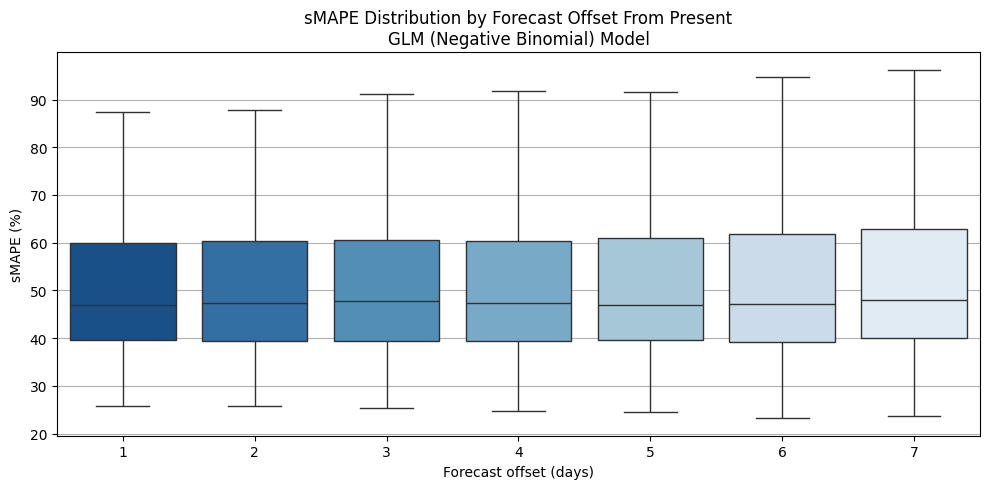

In [273]:
# Convert wide-format sMAPE matrix to long format
smape_long_df = smape_df.melt(id_vars="Product", 
                               var_name="Horizon", 
                               value_name="sMAPE")

# Extract numeric horizon and sort
smape_long_df["Horizon"] = smape_long_df["Horizon"].str.replace("Horizon_", "").astype(int)

# Create a shades-of-blue palette from dark to light (reversed Blues)
palette = sns.color_palette("Blues", n_colors=7)[::-1]  # darkest first

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=smape_long_df, x="Horizon", y="sMAPE", palette=palette, showfliers=False, ax=ax)

ax.set_title("sMAPE Distribution by Forecast Offset From Present\nGLM (Negative Binomial) Model")
ax.set_xlabel("Forecast offset (days)")
ax.set_ylabel("sMAPE (%)")
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

In [278]:
smape_long_df.groupby('Horizon').describe(percentiles=[0.10, 0.25, 0.50, 0.75, 0.90]).round(2)

sMAPE                                                                
         count   mean    std    min    10%    25%    50%    75%    90%     max
Horizon                                                                       
1        142.0  51.21  16.22  25.73  34.14  39.52  47.01  59.98  74.95   99.46
2        142.0  51.43  16.44  25.76  34.10  39.49  47.34  60.37  75.50   99.51
3        142.0  51.60  16.75  25.35  34.12  39.36  47.73  60.61  75.35  100.00
4        142.0  51.70  16.92  24.71  34.38  39.38  47.44  60.44  76.35  100.00
5        142.0  51.76  16.92  24.56  34.23  39.58  47.04  60.91  76.40  100.00
6        142.0  51.74  17.01  23.21  34.17  39.29  47.12  61.87  75.92  100.00
7        142.0  52.60  17.18  23.64  34.79  40.01  47.98  62.81  76.92  100.00

In [213]:
# Compute symmetric absolute percentage error (sAPE) matrix for each day and product
sape_matrix_df = forecast_matrix_df.copy()
for h in range(1, 8):
    pred = sape_matrix_df[h]
    obs = sape_matrix_df["observed"]
    denominator = np.abs(obs) + np.abs(pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        sape = np.where((obs == 0) & (pred == 0), 0, np.abs(pred - obs) / denominator)
    sape_matrix_df[h] = sape * 100  # Convert to percentage

# Calculate mean sAPE per day of week and product for 1-day horizon
sape_df = sape_matrix_df[["Date", "Product", 1]].copy()
sape_df["DayOfWeek"] = sape_df["Date"].dt.day_name()
smape_by_dayofweek = sape_df.groupby(["DayOfWeek", "Product"])[1].mean().reset_index()
smape_by_dayofweek = smape_by_dayofweek.rename(columns={1: "sMAPE"})
smape_by_dayofweek

,DayOfWeek,Product,sMAPE
0,Friday,12 pencils small tube red spotty,60.228785
1,Friday,12 pencils tall tube posy,46.154418
2,Friday,12 pencils tall tube woodland,57.346280
3,Friday,6 ribbons rustic charm,81.020214
4,Friday,60 teatime fairy cake cases,64.510467
...,...,...,...
989,Wednesday,wooden rounders garden set,72.480650
990,Wednesday,wooden school colouring set,60.249448
991,Wednesday,woodland charlotte bag,52.055293
992,Wednesday,world war 2 gliders asstd designs,35.378644


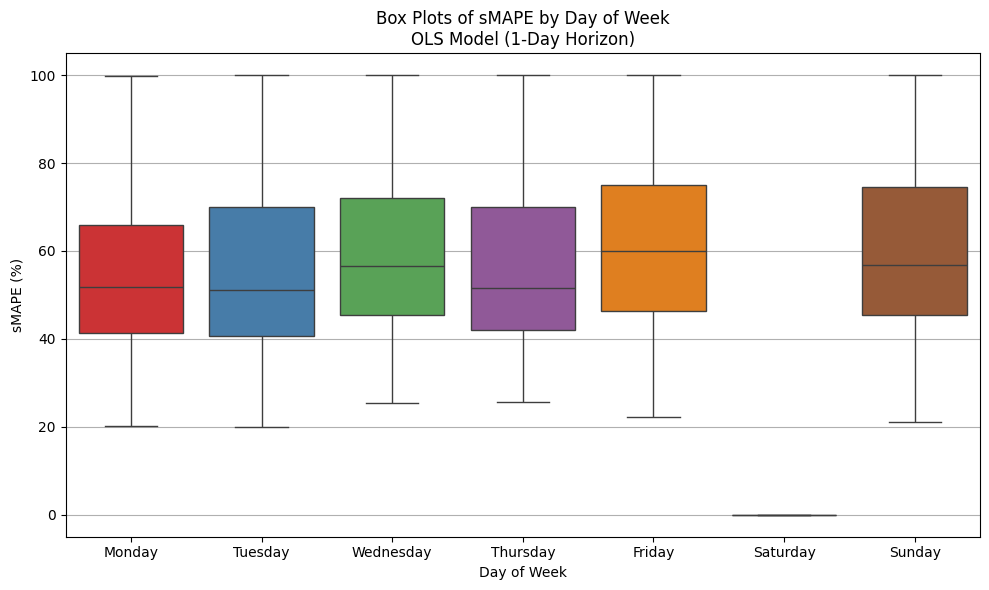

In [214]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Set desired order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot
sns.boxplot(
    x='DayOfWeek',
    y='sMAPE',
    data=smape_by_dayofweek,
    order=day_order,
    showfliers=False,
    palette='Set1'
)

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('sMAPE (%)')
plt.title('Box Plots of sMAPE by Day of Week\nOLS Model (1-Day Horizon)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [281]:
smape_by_dayofweek.groupby('DayOfWeek').describe().round(2)

sMAPE                                                  
           count   mean    std    min    25%    50%    75%     max
DayOfWeek                                                         
Friday     142.0  60.14  19.01  22.34  46.43  59.93  75.04  100.00
Monday     142.0  54.95  18.72  20.27  41.40  51.74  65.90   99.76
Saturday   142.0   9.33  22.89   0.00   0.00   0.00   0.00  100.00
Sunday     142.0  60.73  18.97  21.10  45.52  56.87  74.66  100.00
Thursday   142.0  56.06  18.05  25.73  42.11  51.53  70.04  100.00
Tuesday    142.0  54.43  19.90  20.00  40.62  51.10  70.11  100.00
Wednesday  142.0  59.26  17.69  25.47  45.46  56.54  72.05  100.00

In [282]:
h1_smape = smape_df[['Product', 'Horizon_1']].set_index('Product')['Horizon_1']
q1 = h1_smape.quantile(0.10)
q3 = h1_smape.quantile(0.90)

q1_products = h1_smape[lambda x: x <= q1]
mid_products = h1_smape[lambda x: (q1 < x) & (x < q3)]
q3_products = h1_smape[lambda x: x >= q3]

q1_products_sample = q1_products.sample(n=4, replace=False, random_state=42).sort_values()
mid_products_sample = mid_products.sample(n=4, replace=False, random_state=42).sort_values()
q3_products_sample = q3_products.sample(n=4, replace=False, random_state=42).sort_values()

In [289]:
combined_sample = pd.concat([q1_products_sample[0:2], mid_products_sample[0:1], q3_products_sample[0:1]])
combined_sample

Product
lunch bag woodland                  26.664882
fancy font birthday card            32.798204
cream sweetheart mini chest         36.216136
retro spot tea set ceramic 11 pc    81.448640
Name: Horizon_1, dtype: float64

In [290]:
def plot_forecast_grid(products, train_df, val_df, forecast_df, smape_series, title, ncols=4):
    """
    Plot a grid of forecast panels for given products showing the 60 days of training data,
    all of test data, and model forecasts.

    Args:
        products: list of product names (str)
        train_df: DataFrame with training data (columns: Description, Date, UnitsSold)
        val_df: DataFrame with validation+test data (columns: Description, Date, UnitsSold)
        forecast_df: DataFrame with predictions (columns: Product, Date, 1 for forecast, observed)
        smape_series: Series with sMAPE values indexed by Product
        title: Title of the full figure
        ncols: number of columns in the plot grid
    """
    n = len(products)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3 * nrows))
    axs = axs.flatten()

    fig.suptitle(title, fontweight='bold', fontsize=14)

    for ax, product in zip(axs, products):
        mape = round(smape_series.loc[product], 2)

        product_train = train_df.query('Description == @product').sort_values("Date")
        product_val = val_df.query('Description == @product').sort_values("Date")
        product_forecast = forecast_df.query('Product == @product').sort_values("Date")

        if not product_train.empty:
            last_train_date = product_train["Date"].max()
            cutoff = last_train_date - timedelta(days=60)
            train_series = product_train[product_train["Date"] > cutoff].set_index("Date")["UnitsSold"]
            train_series.plot(ax=ax, color='tab:blue', label='training')
        
        if not product_val.empty:
            val_series = product_val.set_index("Date")["UnitsSold"]
            val_series.plot(ax=ax, color='tab:grey', alpha=0.6, label='observed')
        
        if not product_forecast.empty:
            pred_series = product_forecast.set_index("Date")[1]
            pred_series = pred_series.clip(lower=0, upper=500)  # Adjust upper limit as needed
            pred_series.plot(ax=ax, color='tab:orange', alpha=0.6, label='predicted')

        ax.set_title(f'{product.capitalize()} - sMAPE: {mape:.2f}%', fontsize=9)
        ax.set_xlabel('Date')
        ax.set_ylabel('Units sold')
        ax.grid(True)
        ax.legend()
        make_axes_human_readable(ax)

    for j in range(len(products), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

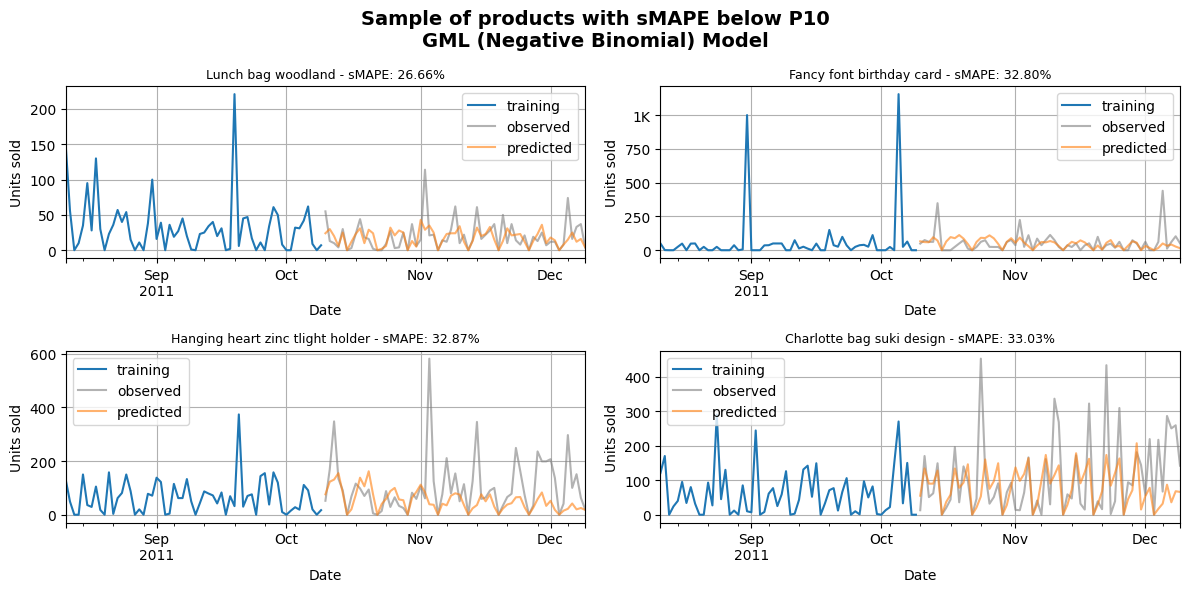

In [225]:
plot_forecast_grid(
    products=q1_products_sample.index.tolist(),
    train_df=train_df,
    val_df=val_test_df,
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Sample of products with sMAPE below P10\nGML (Negative Binomial) Model",
    ncols=2
)

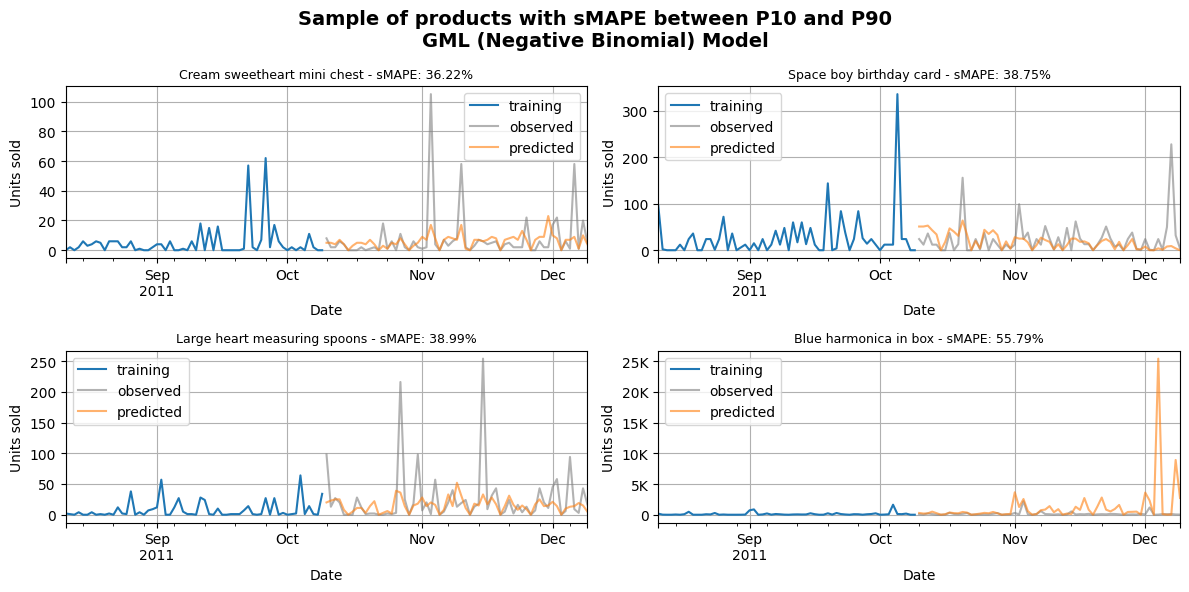

In [218]:
plot_forecast_grid(
    products=mid_products_sample.index.tolist(),
    train_df=train_df,
    val_df=val_test_df,
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Sample of products with sMAPE between P10 and P90\nGML (Negative Binomial) Model",
    ncols=2
)

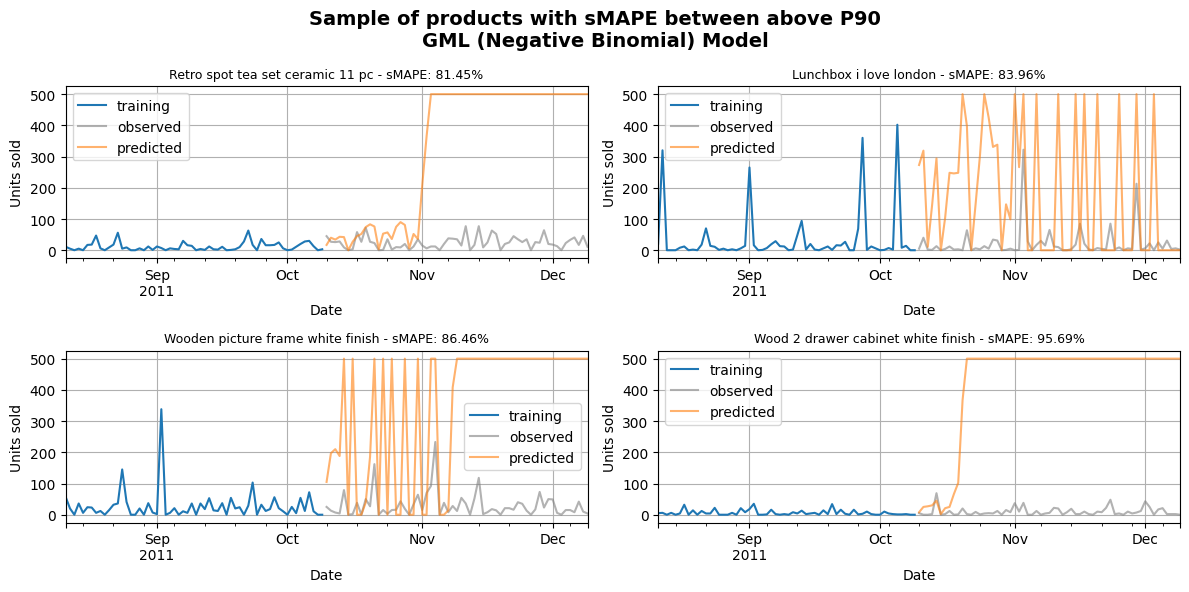

In [226]:
plot_forecast_grid(
    products=q3_products_sample.index.tolist(),
    train_df=train_df,
    val_df=val_test_df,
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Sample of products with sMAPE between above P90\nGML (Negative Binomial) Model",
    ncols=2
)

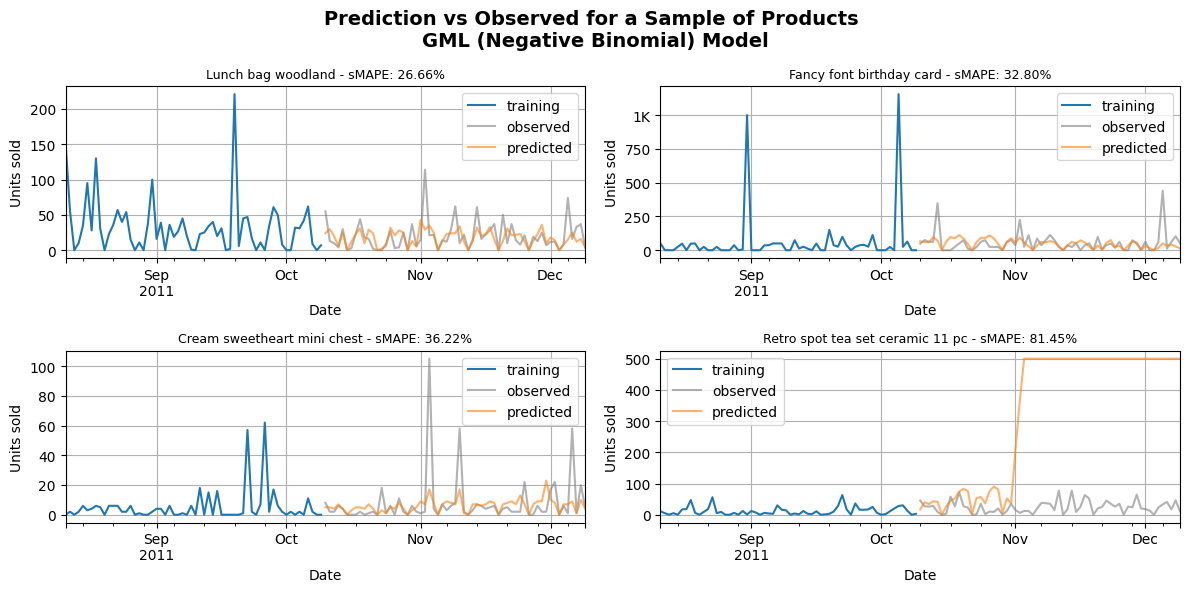

In [293]:
plot_forecast_grid(
    products=combined_sample.index.tolist(),
    train_df=train_df,
    val_df=val_test_df,
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Prediction vs Observed for a Sample of Products \nGML (Negative Binomial) Model",
    ncols=2
)

In [294]:
def plot_log_units_histogram(products, train_df, val_df, forecast_df, smape_series, title, ncols=2):
    """
    Plot a grid of histograms showing the distribution of log-transformed units sold
    for a set of products, using seaborn histplot with KDE.

    Args:
        products: list of product names (str)
        train_df: DataFrame with training data (columns: Description, Date, UnitsSold)
        val_df: DataFrame with validation/test data (columns: Description, Date, UnitsSold)
        forecast_df: DataFrame with predictions (columns: Product, Date, 1 for forecast, observed)
        smape_series: Series with sMAPE values indexed by Product
        title: Title of the full figure
        ncols: number of columns in the plot grid
    """
    n = len(products)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
    axs = axs.flatten()

    fig.suptitle(title, fontweight='bold', fontsize=14)

    for ax, product in zip(axs, products):
        mape = round(smape_series.loc[product], 2)

        # Get log-transformed data for units sold > 0
        train_series = train_df.query('Description == @product and UnitsSold > 0')["UnitsSold"].apply(np.log)
        val_series = val_df.query('Description == @product and UnitsSold > 0')["UnitsSold"].apply(np.log)
        pred_series = forecast_df.query('Product == @product')[1]
        pred_series = pred_series.apply(np.log1p)

        sns.histplot(train_series, kde=True, stat='percent', bins=15, color='tab:blue', label='training', ax=ax, element='step', fill=True)
        sns.histplot(val_series, kde=True, stat='percent', bins=15, color='tab:grey', label='observed', ax=ax, element='step', fill=True)
        sns.histplot(pred_series, kde=True, stat='percent', bins=15, color='tab:orange', label='predicted', ax=ax, element='step', fill=True)

        ax.set_title(f'{product.capitalize()} - sMAPE: {mape:.2f}%', fontsize=10)
        ax.set_xlabel('log1p(Units sold)')
        ax.set_ylabel('Frequency (%)')
        ax.grid(True)
        ax.legend()

    for j in range(len(products), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

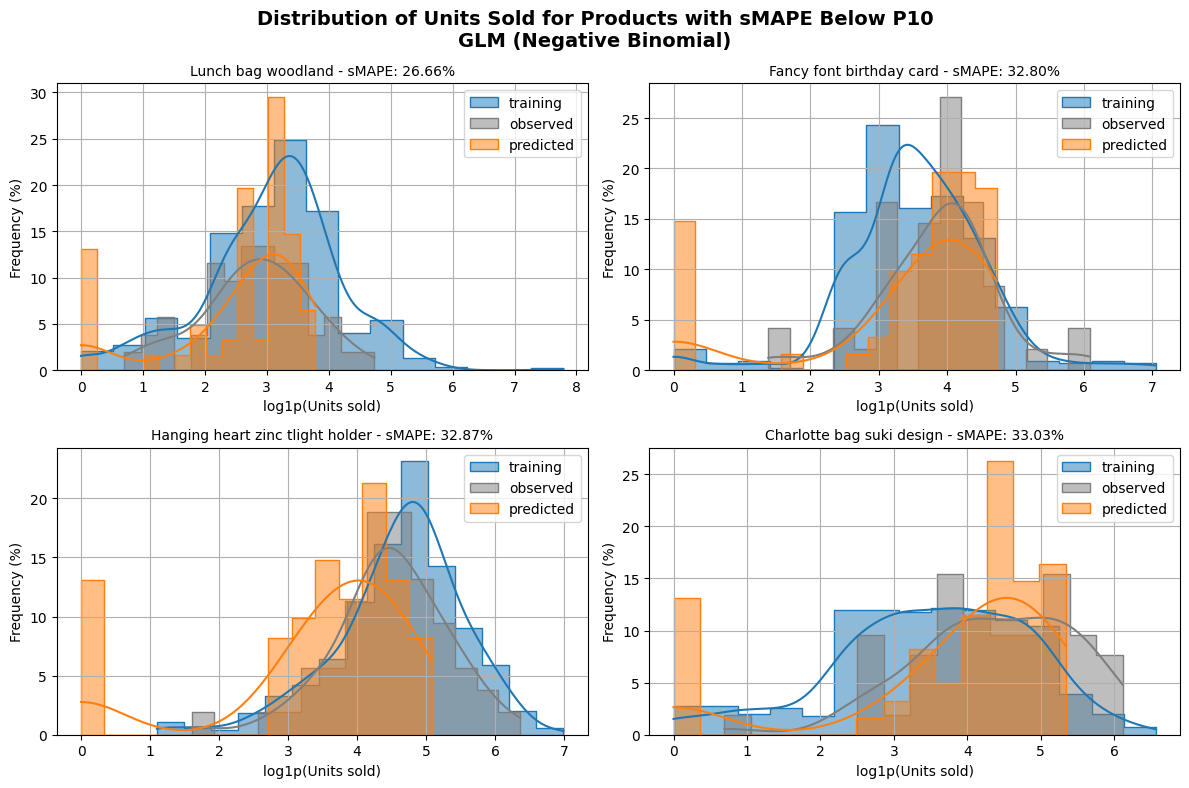

In [238]:
plot_log_units_histogram(
    products=q1_products_sample.index.tolist(),
    train_df=train_df,
    val_df=val_test_df,
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Distribution of Units Sold for Products with sMAPE Below P10\nGLM (Negative Binomial)",
    ncols=2
)

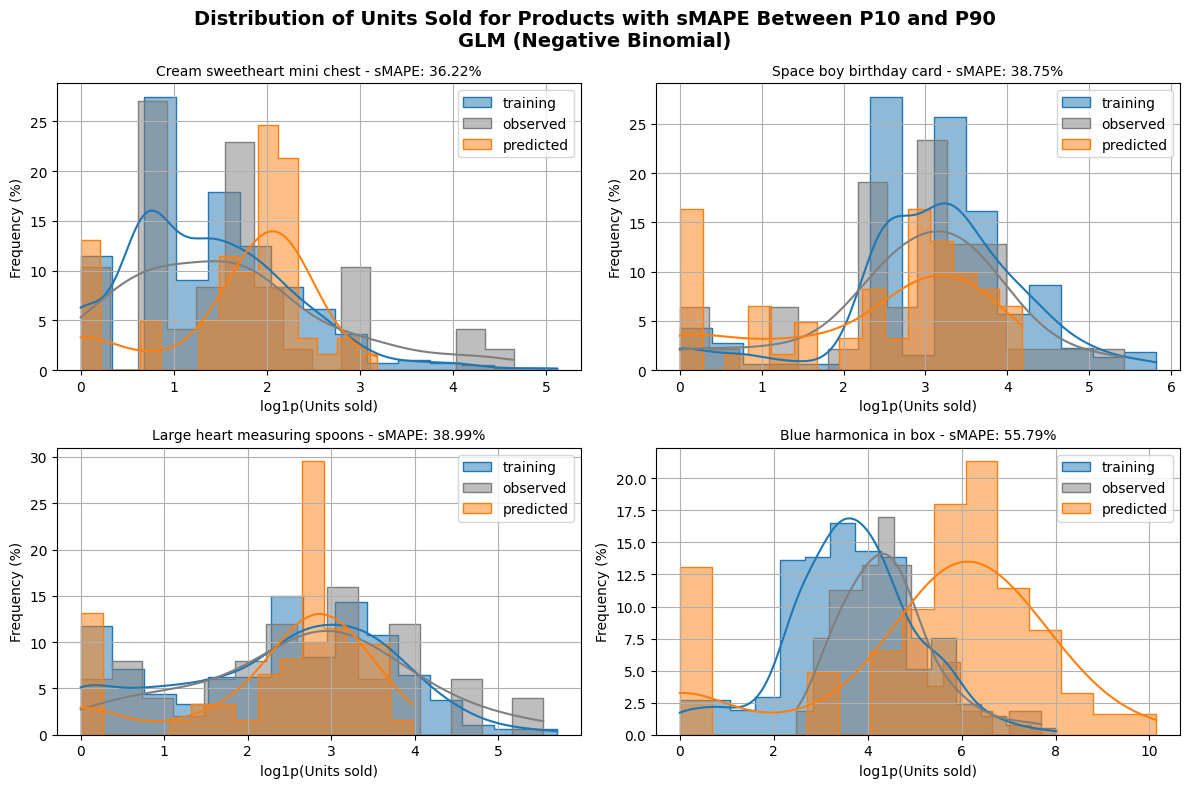

In [239]:
plot_log_units_histogram(
    products=mid_products_sample.index.tolist(),
    train_df=train_df,
    val_df=val_test_df,
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Distribution of Units Sold for Products with sMAPE Between P10 and P90\nGLM (Negative Binomial)",
    ncols=2
)

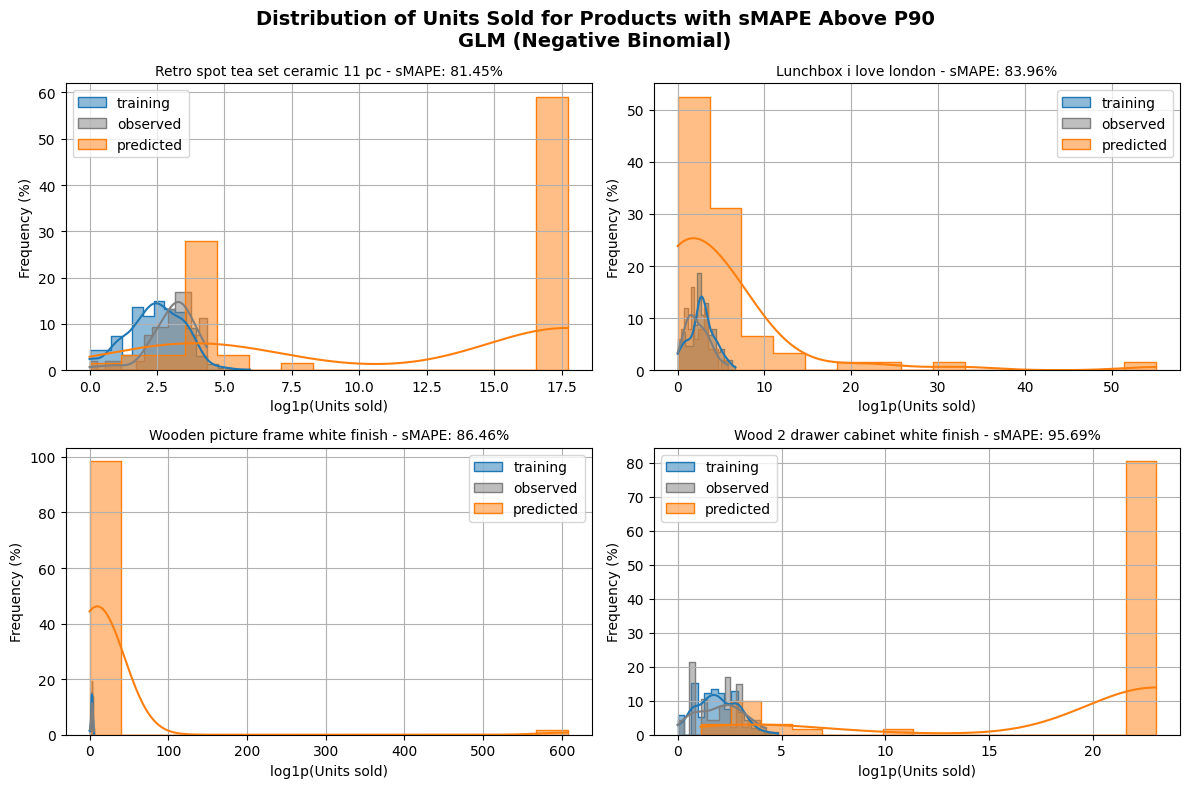

In [240]:
plot_log_units_histogram(
    products=q3_products_sample.index.tolist(),
    train_df=train_df,
    val_df=val_test_df,
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Distribution of Units Sold for Products with sMAPE Above P90\nGLM (Negative Binomial)",
    ncols=2
)

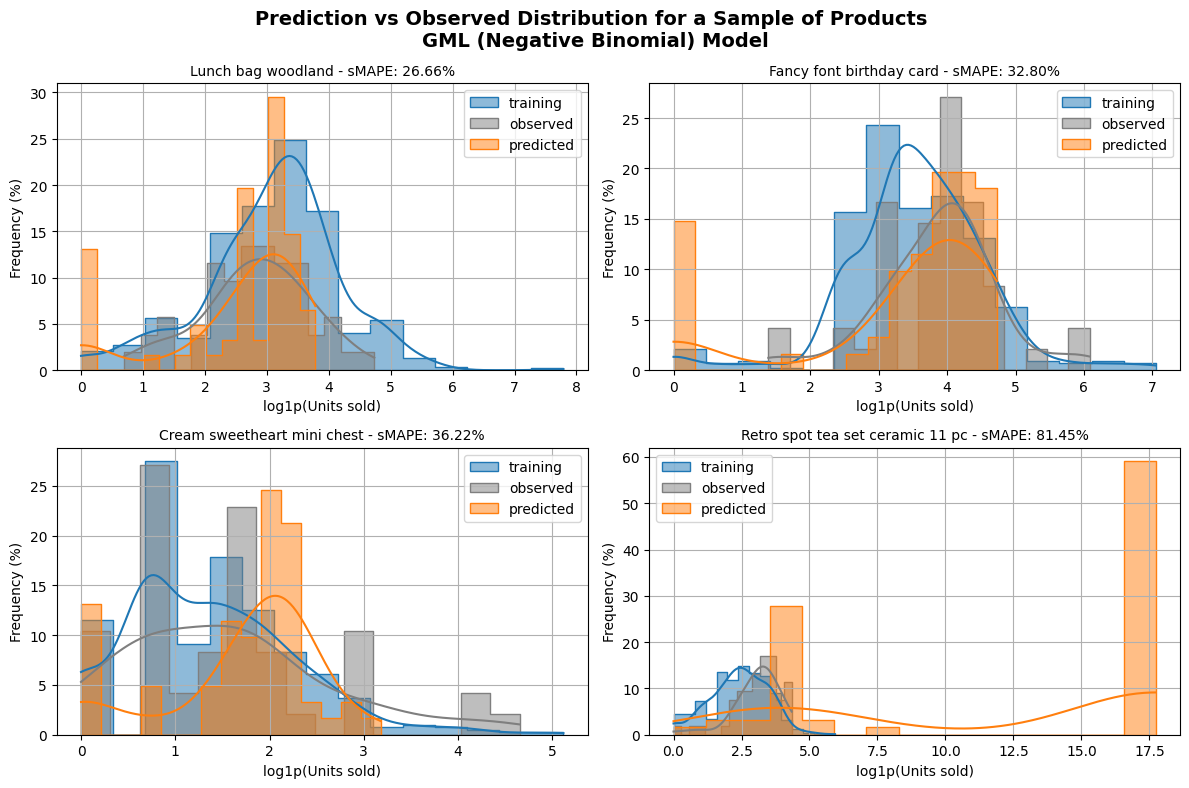

In [296]:
plot_log_units_histogram(
    products=combined_sample.index.tolist(),
    train_df=train_df,
    val_df=val_test_df,
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Prediction vs Observed Distribution for a Sample of Products \nGML (Negative Binomial) Model",
    ncols=2
)

In [246]:
def plot_pred_vs_actual_scatter(products, forecast_df, smape_series, title, ncols=2):
    """
    Plot scatter plots comparing predicted vs. actual units sold for a list of products.
    Includes a y = x reference line.

    Args:
        products: list of product names (str)
        forecast_df: DataFrame with predictions (columns: Product, Date, 1 for forecast, observed)
        smape_series: Series with sMAPE values indexed by Product
        title: Title of the full figure
        ncols: number of columns in the plot grid
    """
    n = len(products)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
    axs = axs.flatten()

    fig.suptitle(title, fontweight='bold', fontsize=14)

    for ax, product in zip(axs, products):
        df = forecast_df.query("Product == @product")[["observed", 1]].dropna()
        df = df[df["observed"] >= 0]
        df = df[df[1] >= 0]

        mape = round(smape_series.loc[product], 2)

        ax.scatter(df["observed"], df[1], alpha=0.6, color='tab:orange', edgecolor='k', s=30, label='')
        min_val = min(df["observed"].min(), df[1].min())
        max_val = max(df["observed"].max(), df[1].max())
        ax.plot([min_val, max_val], [min_val, max_val], color='tab:blue', linestyle='--', label='observed = forecast')

        ax.set_title(f'{product.capitalize()} - sMAPE: {mape:.2f}%', fontsize=10)
        ax.set_xlabel('Observed Units Sold')
        ax.set_ylabel('Predicted Units Sold')
        ax.grid(True)
        ax.legend()

    for j in range(len(products), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


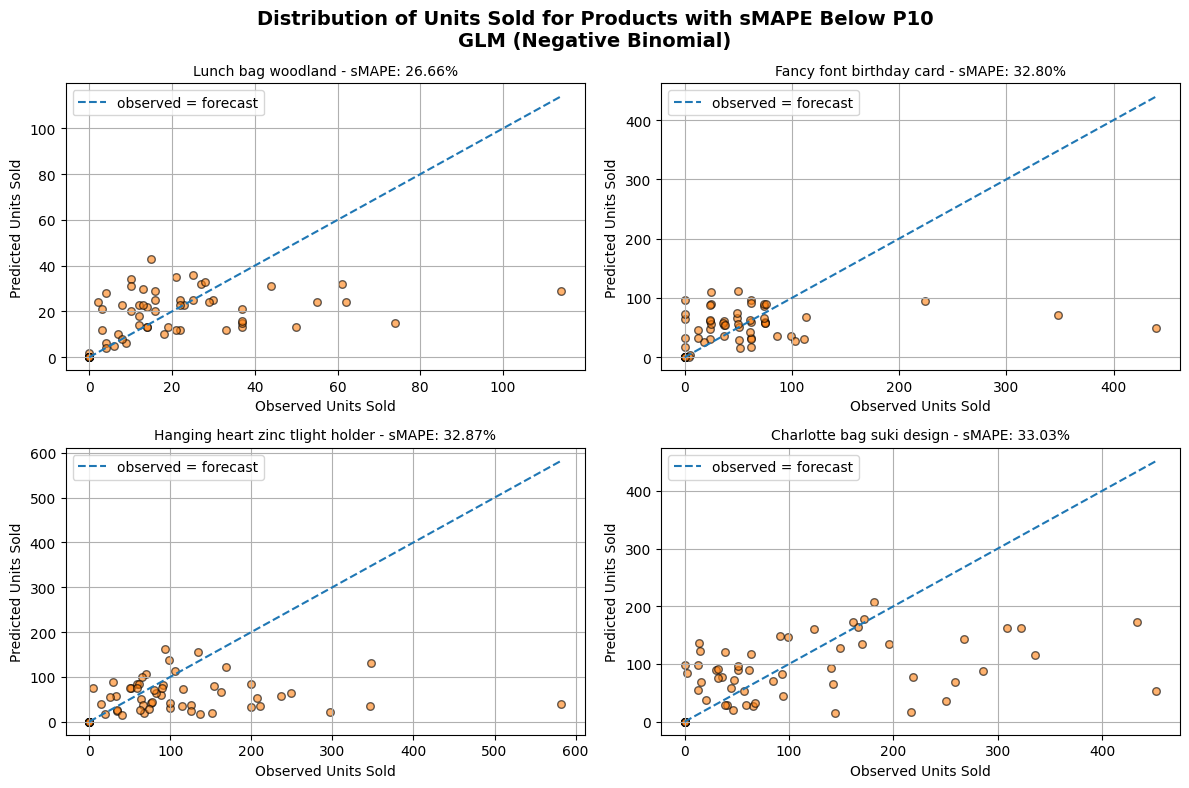

In [248]:
plot_pred_vs_actual_scatter(
    products=q1_products_sample.index.tolist(),
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Distribution of Units Sold for Products with sMAPE Below P10\nGLM (Negative Binomial)",
    ncols=2
)

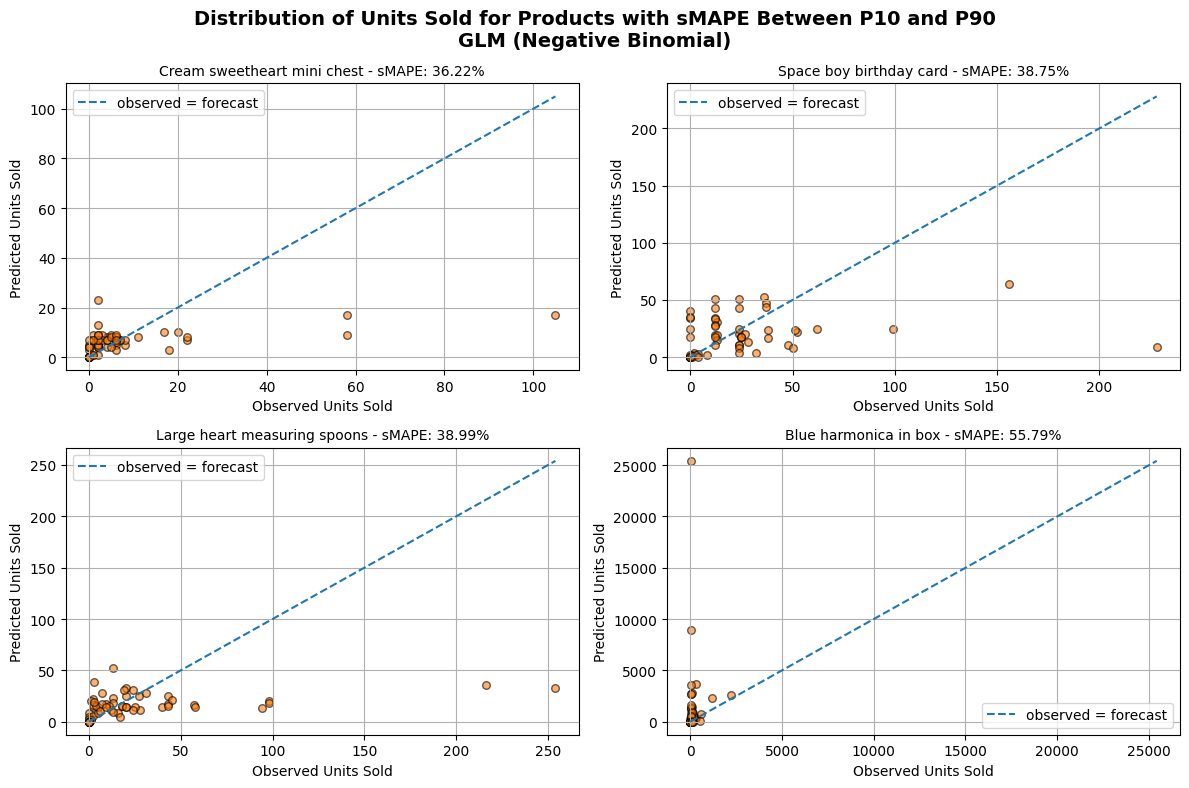

In [249]:
plot_pred_vs_actual_scatter(
    products=mid_products_sample.index.tolist(),
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Distribution of Units Sold for Products with sMAPE Between P10 and P90\nGLM (Negative Binomial)",
    ncols=2
)

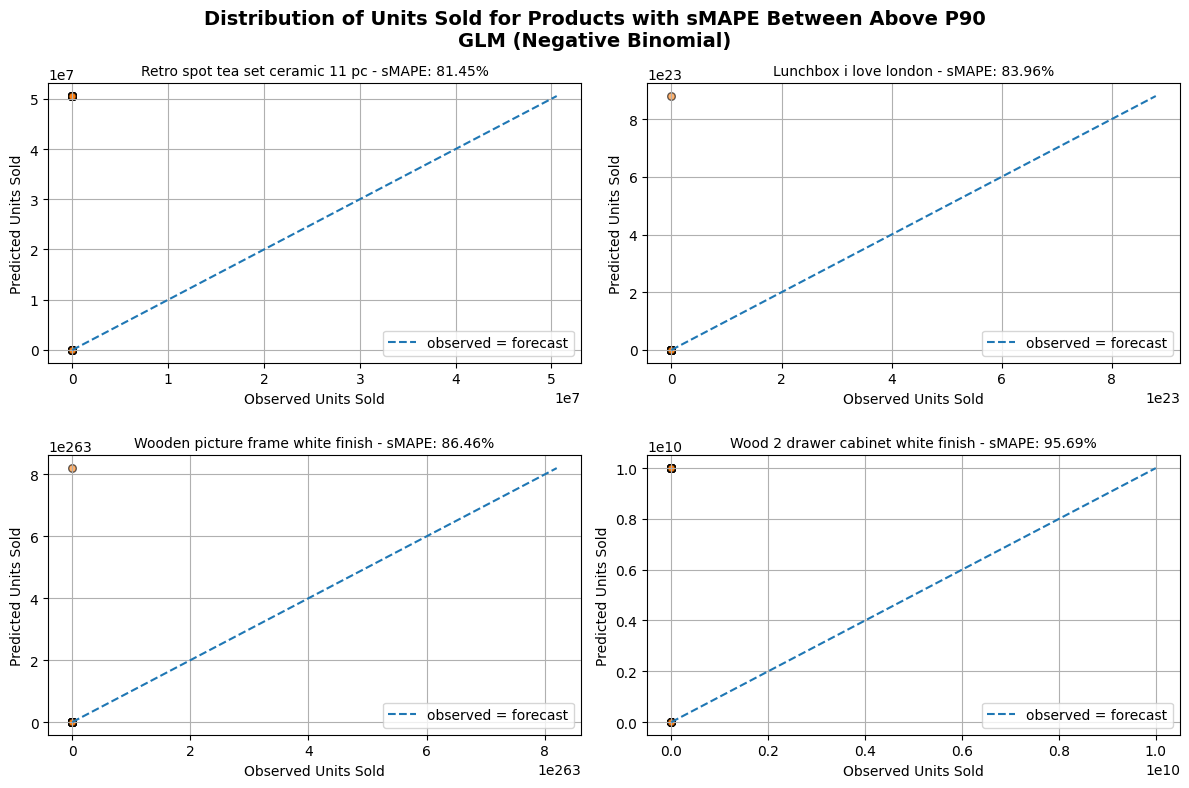

In [250]:
plot_pred_vs_actual_scatter(
    products=q3_products_sample.index.tolist(),
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Distribution of Units Sold for Products with sMAPE Between Above P90\nGLM (Negative Binomial)",
    ncols=2
)

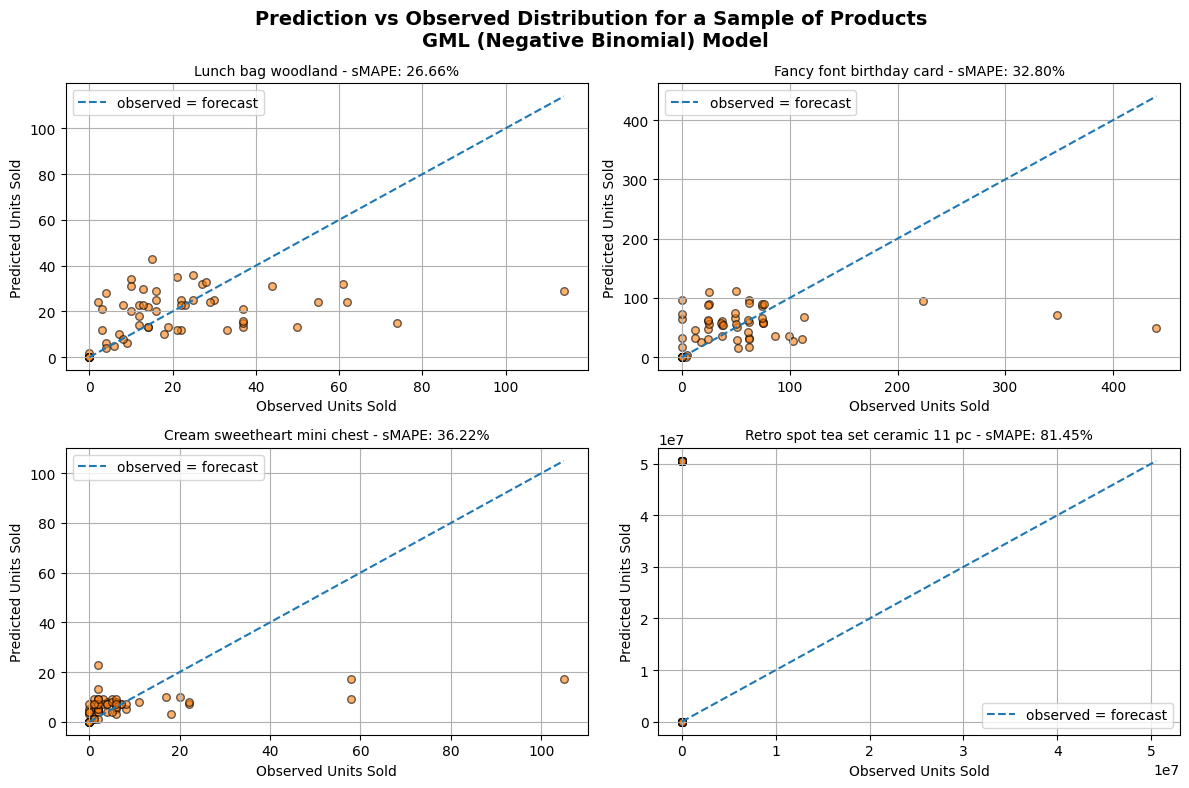

In [298]:
plot_pred_vs_actual_scatter(
    products=combined_sample.index.tolist(),
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Prediction vs Observed Distribution for a Sample of Products \nGML (Negative Binomial) Model",
    ncols=2
)

In [253]:
def plot_residuals_vs_prediction_with_loess(products, forecast_df, smape_series, title, ncols=2):
    """
    Plot residuals (predicted - actual) against predicted values with a LOESS smoothing line.

    Args:
        products: list of product names (str)
        forecast_df: DataFrame with predictions (Product, Date, observed, 1)
        smape_series: Series with sMAPE values indexed by Product
        title: Title for the entire plot grid
        ncols: Number of columns in subplot grid
    """
    n = len(products)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3.5 * nrows))
    axs = axs.flatten()

    fig.suptitle(title, fontweight='bold', fontsize=14)

    for ax, product in zip(axs, products):
        df = forecast_df.query("Product == @product")[["observed", 1]].dropna()
        df = df[(df["observed"] >= 0) & (df[1] >= 0)]
        df["residual"] = df[1] - df["observed"]

        mape = round(smape_series.loc[product], 2)

        sns.scatterplot(x=df[1], y=df["residual"], ax=ax, color='tab:red', edgecolor='k', s=30, alpha=0.6, label='Residual')
        sns.regplot(x=df[1], y=df["residual"], ax=ax, scatter=False, color='black', lowess=True, label='LOESS')

        ax.axhline(0, linestyle='--', color='grey', linewidth=1)
        ax.set_title(f"{product.capitalize()} - sMAPE: {mape:.2f}%", fontsize=10)
        ax.set_xlabel("Predicted Units Sold")
        ax.set_ylabel("Residual (Pred - Actual)")
        ax.grid(True)
        ax.legend()

    for j in range(len(products), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

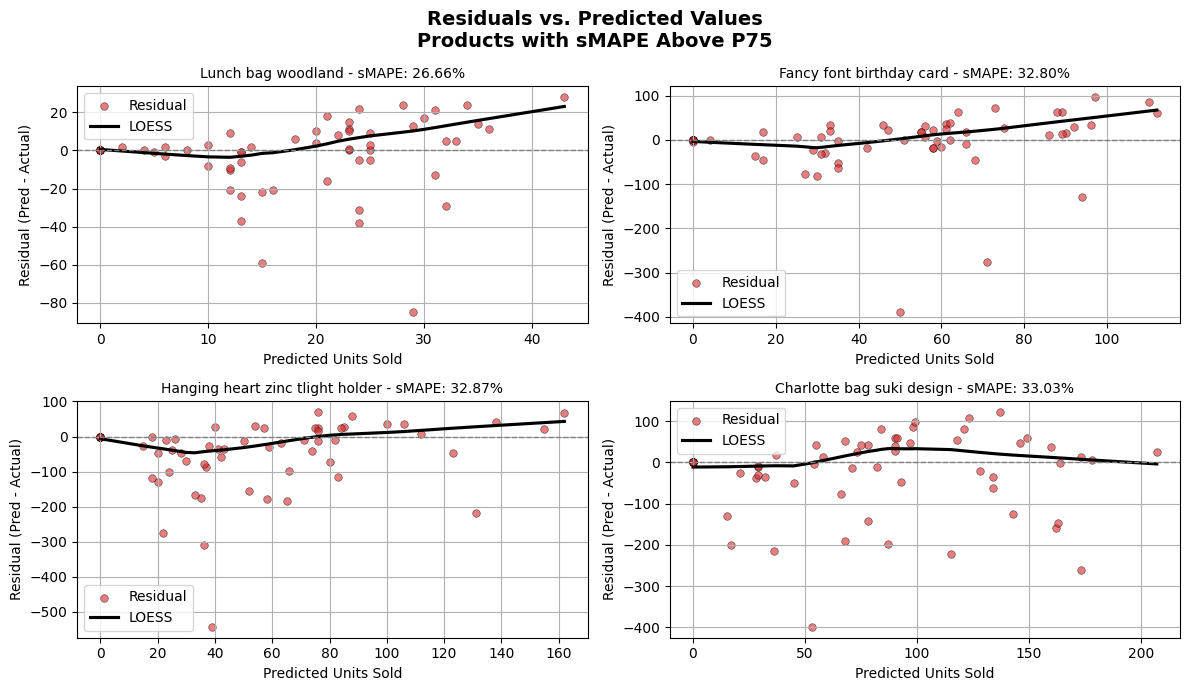

In [ ]:
plot_residuals_vs_prediction_with_loess(
    products=q1_products_sample.index.tolist(),
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Residuals vs. Predicted Values\nProducts with sMAPE Below P10",
    ncols=2
)

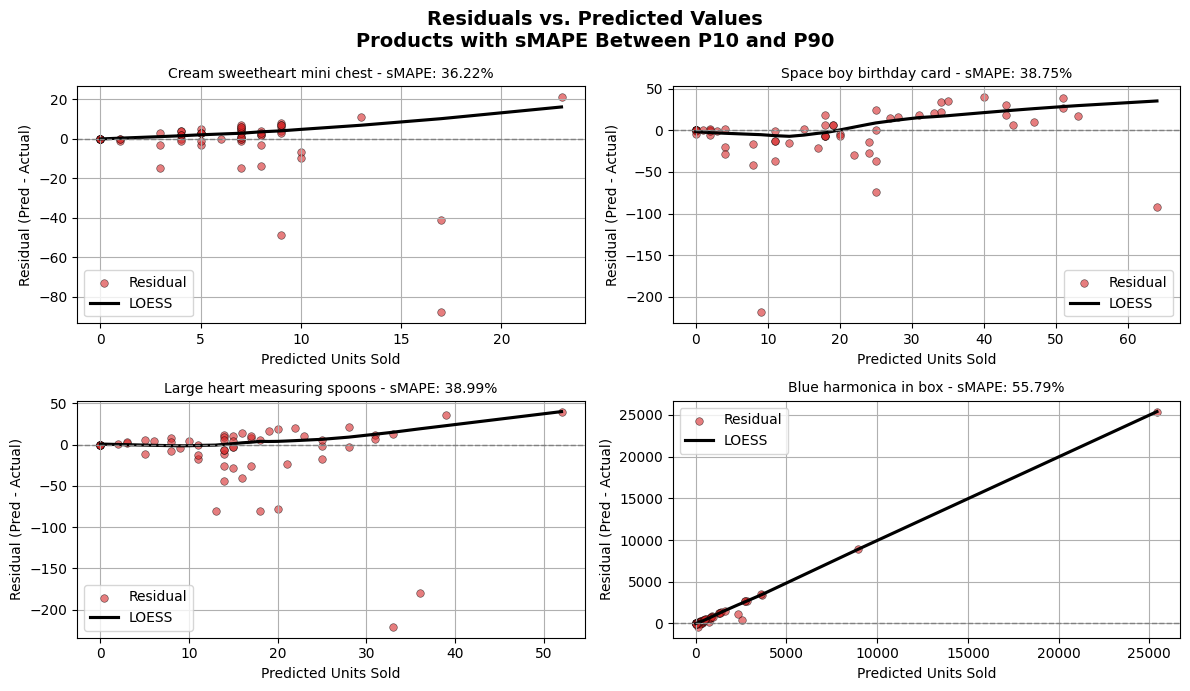

In [260]:
plot_residuals_vs_prediction_with_loess(
    products=mid_products_sample.index.tolist(),
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Residuals vs. Predicted Values\nProducts with sMAPE Between P10 and P90",
    ncols=2
)

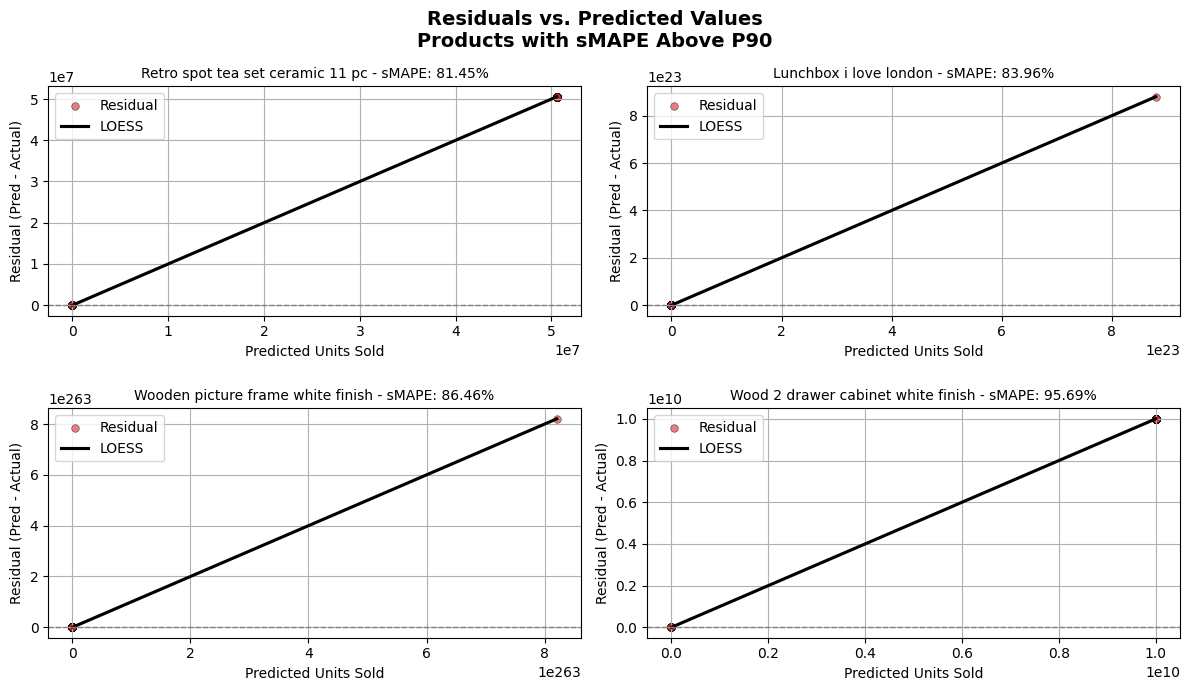

In [261]:
plot_residuals_vs_prediction_with_loess(
    products=q3_products_sample.index.tolist(),
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Residuals vs. Predicted Values\nProducts with sMAPE Above P90",
    ncols=2
)

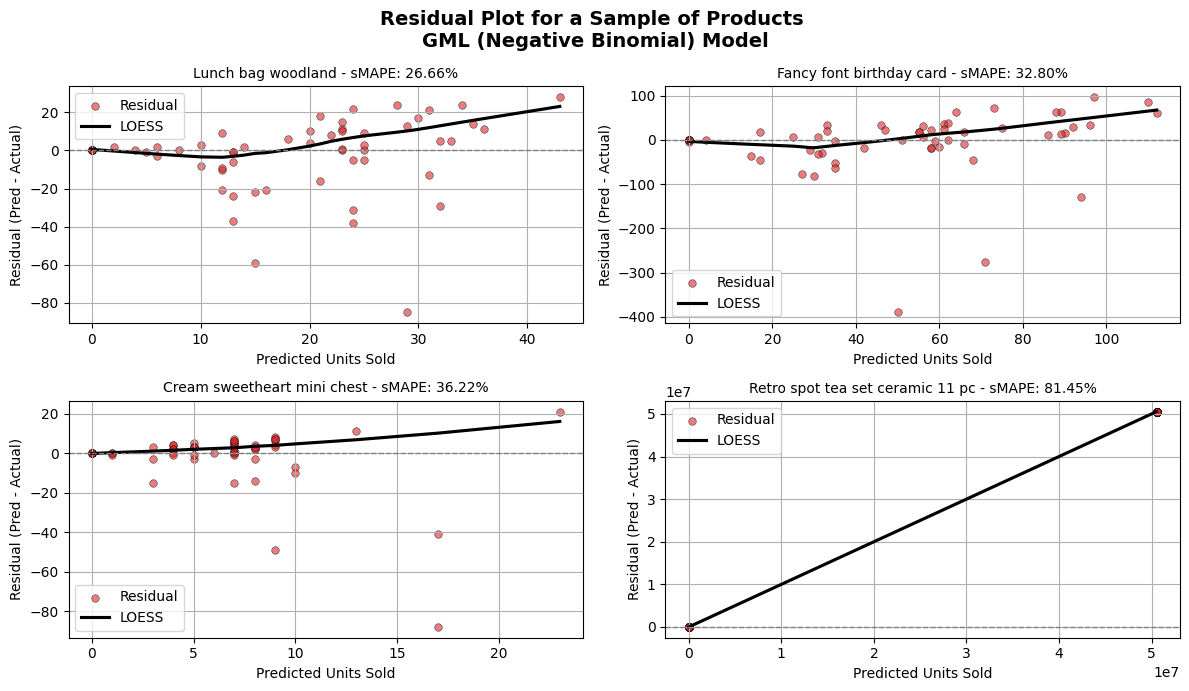

In [299]:
plot_residuals_vs_prediction_with_loess(
    products=combined_sample.index.tolist(),
    forecast_df=forecast_matrix_df,
    smape_series=h1_smape,
    title="Residual Plot for a Sample of Products \nGML (Negative Binomial) Model",
    ncols=2
)

In [258]:
def plot_product_horizon_smape_heatmap(smape_df_matrix, title="Product-Level sMAPE Heatmap by Horizon"):
    """
    Create a heatmap of sMAPE values by product and forecast horizon.

    Args:
        smape_df_matrix: DataFrame with one row per product, columns Horizon_1 ... Horizon_7
        title: Plot title
    """
    smape_matrix = smape_df_matrix.set_index("Product").copy()
    smape_matrix.columns = [col.replace("Horizon_", "Day ") for col in smape_matrix.columns]

    # Sort by average sMAPE across horizons
    smape_matrix["Average"] = smape_matrix.mean(axis=1)
    smape_matrix = smape_matrix.sort_values("Average", ascending=False).drop(columns="Average")

    plt.figure(figsize=(12, max(6, len(smape_matrix) * 0.25)))
    sns.heatmap(smape_matrix, annot=False, cmap="YlOrRd", linewidths=0.5, linecolor="grey", cbar_kws={'label': 'sMAPE (%)'})
    plt.title(title, fontweight="bold")
    plt.xlabel("Forecast Horizon")
    plt.ylabel("Product")
    plt.tight_layout()
    plt.show()

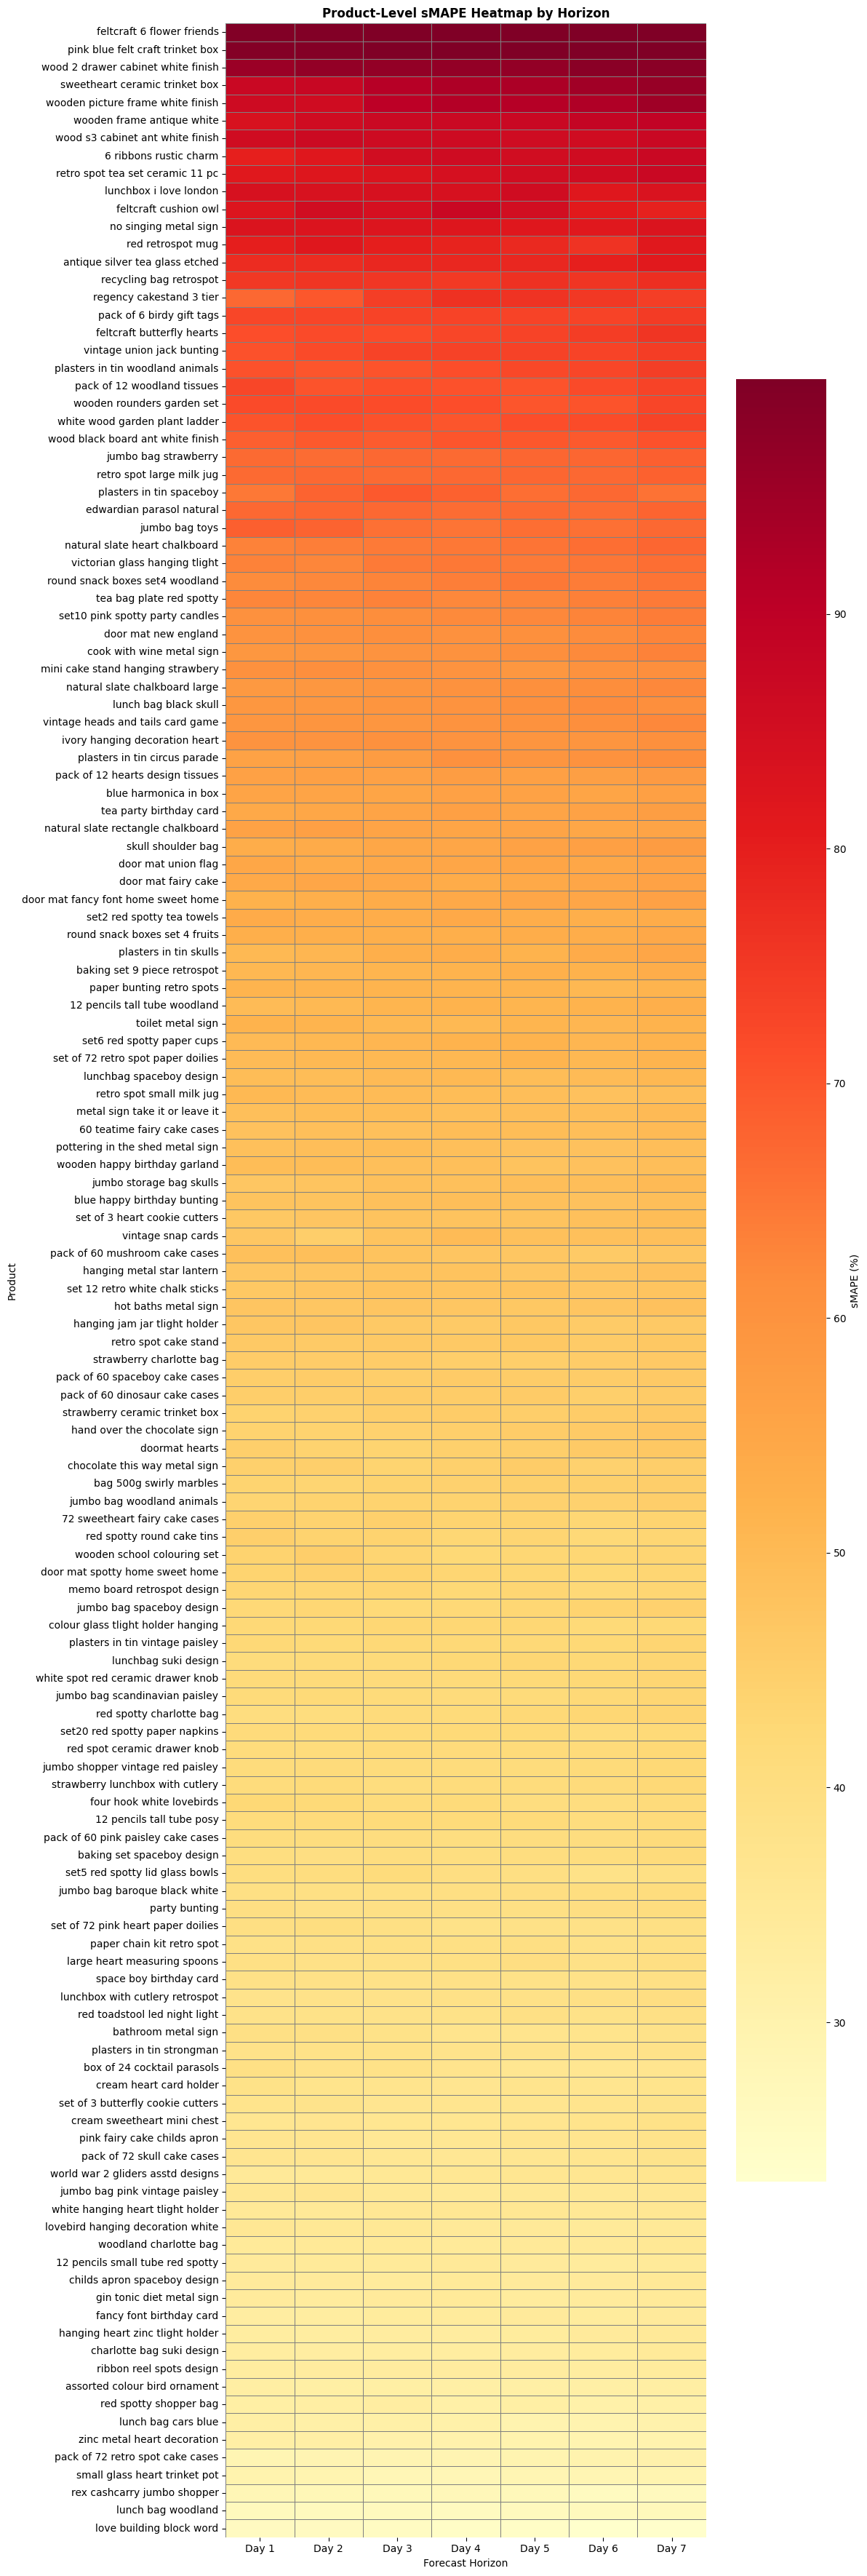

In [259]:
plot_product_horizon_smape_heatmap(smape_df)